### Advanced Data Assimilation using Ensemble Smoother Multiple Data Assimilation (ESMDA) in Reservoir Simulation

This notebook demonstrates how to apply Ensemble Smoother Multiple Data Assimilation (ESMDA) in reservoir simulation. ESMDA is a data assimilation method that integrates observations and models to produce an improved estimate of the state of a system—in this case, a synthetic reservoir.

# Objectives
Understand the ESMDA algorithm for data assimilation 

Explore the effect of different ensemble sizes, perturbations, and number of assimilation steps

Analyze the convergence and effectiveness of the ESMDA method in a synthetic reservoir model
# Prerequisites
Knowledge of Python

Familiarity with Data Assimilation Methods

Understanding of Reservoir Simulation Models

## Understanding the reservoir simulator

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from reservoir_simulator import ReservoirSim 
import numpy as np
from scipy import stats


# Random number generator
rng = np.random.default_rng()

In [7]:
nx=25
ny=25
perm_field = np.ones(ny * ny) * 100  # Replace with your actual perm field
reservoir = ReservoirSim(nx=nx, ny=ny ,perm_field=perm_field)
pressure_history = reservoir.simulate()


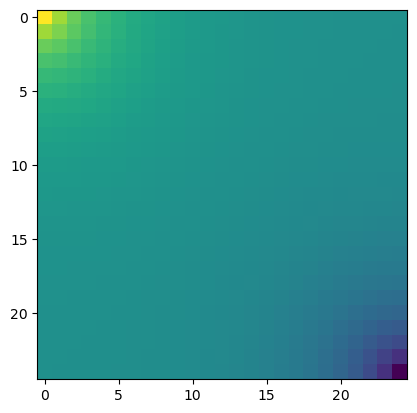

In [8]:
pressure_history = pressure_history.reshape((pressure_history.shape[0], nx,ny))
plt.imshow(pressure_history[-1,:,:])


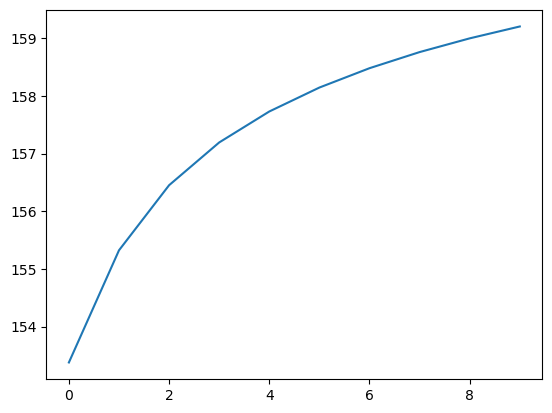

In [9]:
plt.plot(pressure_history[:,1,1])

## Create permeability maps for for ESMDA

We will create a set of permeability maps that will serve as our initial guess (prior). These maps are generated using a Gaussian random field and are constrained by certain statistical properties.



In [10]:

#create 101 random permeability fields with mean 10 and std 1
##### USE GASPARHI COHN TO COMPUTE PERM
Ni = nx
Nj = ny
NGrid = Ni * Nj
Ne = 100

def CalcHL(x0, x1, L, theta):
    cosT = np.cos(theta)
    sinT = np.sin(theta)
    dx = x1[0] - x0[0]
    dy = x1[1] - x0[1]

    dxRot = np.array([[cosT, -sinT], [sinT, cosT]]) @ np.array([[dx], [dy]])
    dxFlat = dxRot.flatten()

    return np.sqrt((dxFlat[0]/L[0])**2 + (dxFlat[1]/L[1])**2)

# Calc covariance between two gridblocks
def SphereFunction(x0, x1, L, theta, sigmaPr2):
    hl = CalcHL(x0, x1, L, theta)

    if (hl > 1):
        return 0
    
    return sigmaPr2 * (1.0 - 3.0/2.0*hl + (hl**3)/2)

def GaspariCohnFunction(x0, x1, L, theta):
    hl = CalcHL(x0, x1, L, theta)

    if (hl < 1):
        return -(hl**5)/4. + (hl**4)/2. + (hl**3)*5./8. - (hl**2)*5./3. + 1.
    if (hl >= 1 and hl < 2):
        return (hl**5)/12. - (hl**4)/2. + (hl**3)*5./8. + (hl**2)*5./3. - hl*5 + 4 - (1/hl)*2./3.
    
        return 0

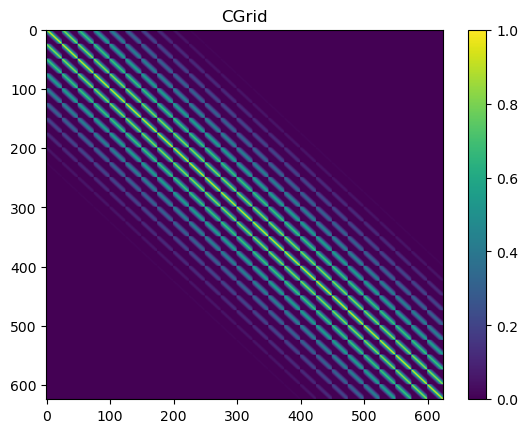

In [11]:
# Covariogram parameters 
L = (10,10) 
theta = 45 * np.pi/180 #degrees
sigmaPr2 = 1.0
csi = 0.99

    # convert index numeration to I J index
def IndexToIJ(index, ni, nj):
    return ((index % ni) + 1, (index // ni) + 1)

# Convert i J numeration to index
def IJToIndex(i,j,ni,nj):
    return (i-1) + (j-1)*ni

def BuildPermCovMatrix(Ni, Nj, L, theta, sigmaPr2):
    Nmatrix = Ni * Nj
    Cm = np.empty([Nmatrix, Nmatrix])
    for index0 in range(Nmatrix):
        I0 = IndexToIJ(index0,Ni,Nj)
        for index1 in range(Nmatrix):
            I1 = IndexToIJ(index1,Ni,Nj)
            Cm[index0, index1] = SphereFunction(I0, I1, L, theta, sigmaPr2)
    return Cm

def PlotMatrix(matrix, title, axis, vmin=None, vmax=None):
    axis.set_title(title)
    return axis.imshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')

def PlotModelRealization(m, title, axis, vmin=None, vmax=None):
    return PlotMatrix(m.reshape((Ni,Nj),order='F').T, title, axis, vmin, vmax)
# Generate the covariance matrix

Cgrid = BuildPermCovMatrix(Ni, Nj, L, theta, sigmaPr2)

fig, ax = plt.subplots()
im = PlotMatrix(Cgrid, 'CGrid', ax)
fig.colorbar(im, ax=ax)

In [12]:
# Generate the ensembles
mpr = np.full((NGrid,1),3.0)
lCholesky = np.linalg.cholesky(Cgrid)
mList = []
for i in range(Ne+1): #+1 for the reference model
    z = np.random.normal(size=(NGrid,1))
    mList.append(mpr + lCholesky @ z)

#MGridPrior remove the first to be the reference model
#clip the mList to min = 0.5 and max = 5 (related to MGrid values)
bound_max= 5
bound_min= 0.5
mList = np.clip(mList, bound_min, bound_max)

mid_index = len(mList) // 2
# Set the middle element as the reference model
MReference = np.array(mList[mid_index])
# Slice the array to exclude the middle element
mList_without_middle = np.concatenate([mList[:mid_index], mList[mid_index+1:]])
# Use the remaining elements for MGridPrior
MGridPrior = np.transpose(np.array(mList_without_middle).reshape((Ne, NGrid)))


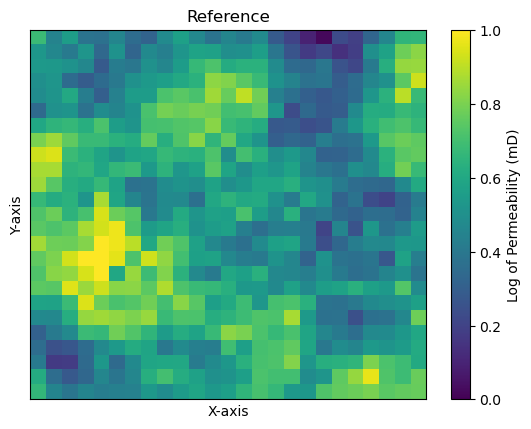

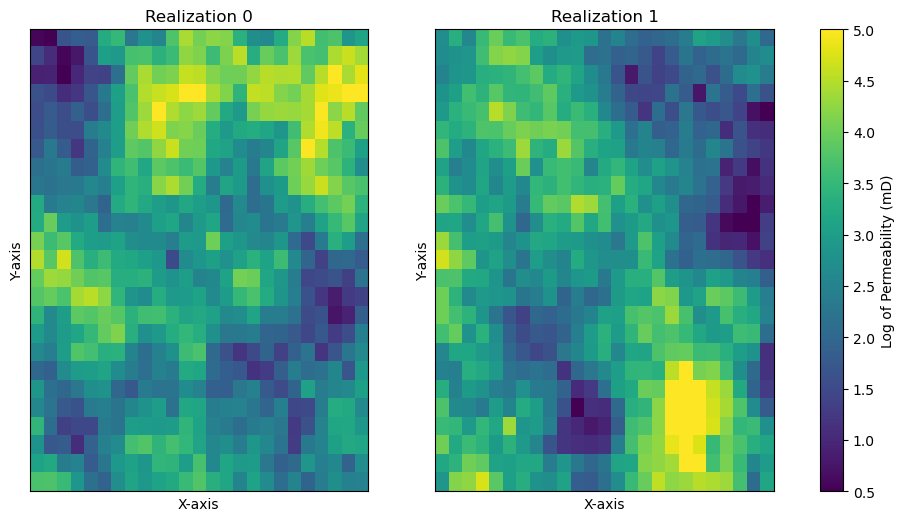

In [13]:
#plot the MReference
fig, ax = plt.subplots(nrows=1, ncols=1)  # You can adjust the number of rows and columns as needed

PlotModelRealization(MReference, 'Reference', ax, vmin=bound_min, vmax=bound_max)
fig.colorbar(im, ax=ax, label='Log of Permeability (mD)')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Create a figure and axis with a specific size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot your data (assuming PlotModelRealization is a custom function you have)
im = PlotModelRealization(MGridPrior[:,0], 'Realization 0', ax[0], vmin=bound_min, vmax=bound_max)
PlotModelRealization(MGridPrior[:,1], 'Realization 1', ax[1], vmin=bound_min, vmax=bound_max)
# Add colorbar
fig.colorbar(im, ax=ax, label='Log of Permeability (mD)')
# Add x and y labels
for axis in ax:
    axis.set_xlabel('X-axis')
    axis.set_ylabel('Y-axis')
    axis.set_xticks([])
    axis.set_yticks([])
# Show the plot
plt.show()

## Run the prior models and the reference case

In [14]:
#simulate all 101 fields
simulated_pressure_history = np.zeros((Ne, pressure_history.shape[0], nx, ny))
for i, perm_field in enumerate(MGridPrior.T):
    reservoir = ReservoirSim(nx, ny, perm_field=np.exp(perm_field))
    pressure_history = reservoir.simulate()
    simulated_pressure_history[i,...] = pressure_history.reshape((pressure_history.shape[0], nx,ny))

simulated_pressure_history_prior = simulated_pressure_history
#getting only data we will use as observation
DPrior = simulated_pressure_history[:,:,1,1]

In [15]:
#simulate the reference field
reservoir = ReservoirSim(nx, ny, perm_field=np.exp(MReference))
pressure_history = reservoir.simulate()
reference_pressure_history = pressure_history.reshape((pressure_history.shape[0], nx,ny))


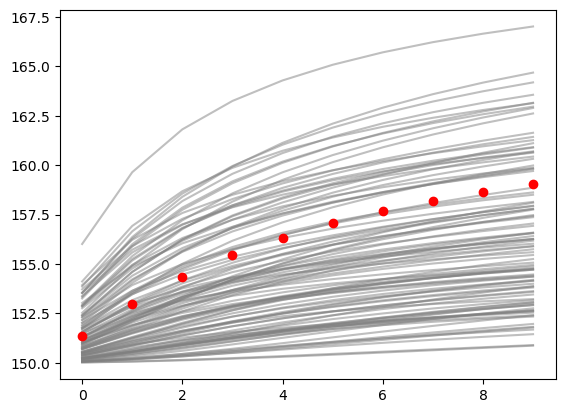

In [16]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
for i in range(Ne):
    plt.plot(simulated_pressure_history[i,:,1,1], color='gray', alpha=0.5)
plt.plot(reference_pressure_history[:,1,1], label='reference case' , marker='o', linestyle='', color = 'red')


### Create the perturbed observations for ESMDA

We will create a set of perturbed observations that will serve as our observations for ESMDA. These observations are generated by adding a random noise to the reference case observations.

In [17]:
#using the last model to create synthetic data
# Observations
dObs = reference_pressure_history[:,1,1].flatten()
Nd = len(dObs)
dstd = 2 * np.ones_like(dObs)
# Associated standard deviation: ones (for this scenario)
dstd = np.ones(dObs.size)*0.1
Ce = np.diag(dstd**2)


### ESMDA

Here we implement the ESMDA algorithm. This involves multiple assimilation steps, where we update our model parameters using observed data. The key components include:

Perturbing the observed data.

Calculating the Kalman gain.

Updating the model parameters.

Each assimilation step refines our model parameters, aiming to reduce the discrepancy between the model and the observed data.

In [18]:
Na = 4 #number of assimilation steps
alphas = np.ones(Na)*Na
D=np.zeros((Nd,Ne))
MGrid=np.zeros((NGrid,Ne))

In [19]:
l=0
D_iterations=[]
for alpha_idx, alpha in enumerate(alphas):
    print(f"\nAssimilation step {l}")  
    Dobs = np.transpose(dObs + alphas[0]*dstd*np.random.randn(Ne,Nd)) #perturb the observation for each ensemble member
    
    if l==0:   
        MGrid = MGridPrior
        D = DPrior 
        
    else:
        
        total_simulations = Ne
        
        simulated_pressure_history = np.zeros((Ne, pressure_history.shape[0], nx, ny))
        for i, perm_field in enumerate(MGrid.T):
            reservoir = ReservoirSim(nx, ny, perm_field=np.exp(perm_field))
            pressure_history = reservoir.simulate()
            simulated_pressure_history[i,...] = pressure_history.reshape((pressure_history.shape[0], nx,ny))
        #getting only data we will use as observation
        D = simulated_pressure_history[:,:,1,1]   
        

    D_iterations.append(D)

            
   
    deltaM = np.transpose(MGrid.T-MGrid.mean(axis=1)) #mean of the ensemble parameters
    deltaD = D.T-D.mean(axis=1) #mean of the ensemble data
    K = (deltaM@deltaD.T)@np.linalg.inv((deltaD@deltaD.T + alphas[0]*(Ne-1)*Ce)) #Kalman gain
    Mnew = MGrid + K@(Dobs-D.T) #update the ensemble parameters
    MGrid= np.clip(Mnew, bound_min, bound_max) #clip the ensemble parameters to min = 0.5 and max = 5 (related to MGrid values)  
       
    
    
    l += 1
MGridPost = MGrid



Assimilation step 0

Assimilation step 1

Assimilation step 2

Assimilation step 3


### Posterior Analysis
After running ESMDA, it's crucial to analyze the posterior ensemble of models. Here, we visualize the first three realizations from both the prior and posterior ensembles to see how the models have been updated.

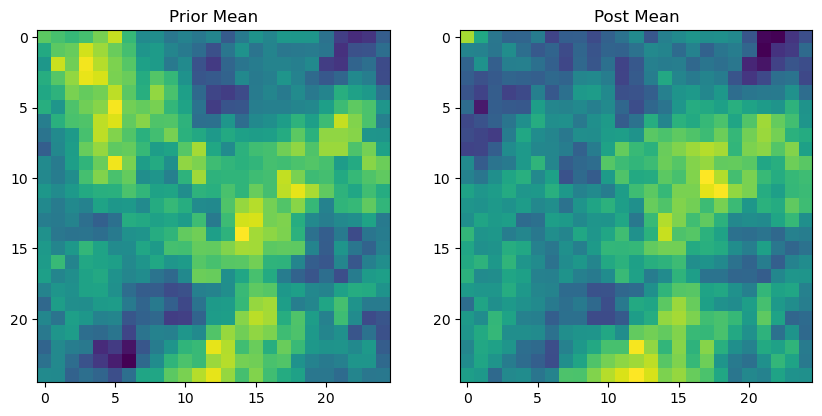

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(MGridPrior.mean(axis=1).reshape(nx,ny), label = 'Prior Mean')
ax[0].set_title('Prior Mean')
ax[1].imshow(MGridPost.mean(axis=1).reshape(nx,ny), label= 'Post Mean')
ax[1].set_title('Post Mean')
plt.show()

In [21]:
#Run the posterior
simulated_pressure_history = np.zeros((Ne, pressure_history.shape[0], nx, ny))
for i, perm_field in enumerate(MGridPost.T):
    reservoir = ReservoirSim(nx, ny, perm_field=np.exp(perm_field))
    pressure_history = reservoir.simulate()
    simulated_pressure_history[i,...] = pressure_history.reshape((pressure_history.shape[0], nx,ny))
DPost = simulated_pressure_history[:,:,1,1]

Observing the monitored pressure at cell (1,1) for all realizations and the reference case, we can see that the ensemble of models after the assimilation steps (in blue) is closer to the reference case (in red) than the prior ensemble (in gray). This indicates that the ESMDA method is effectively updating the models to better represent the observed data.

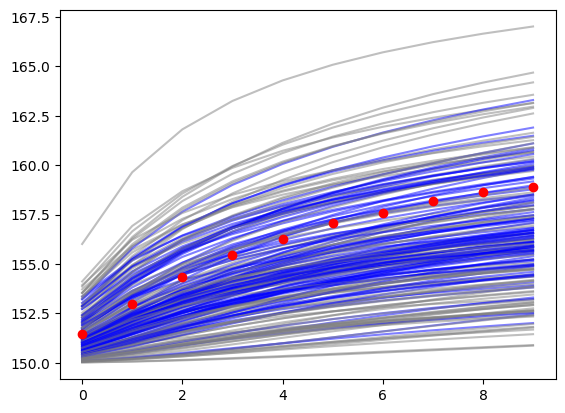

In [22]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
noisy_obs = dObs + np.random.normal(0, dstd , size=len(dObs))

for i in range(Ne):
    plt.plot(DPrior[i,:], color='gray', alpha=0.5)
    plt.plot(DPost[i,:], color='blue', alpha=0.5)
plt.plot(noisy_obs, label='reference case' , marker='o', linestyle='', color = 'red')